In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.optim as optim

from data_helpers import plot_photons_histograms
from model import ConditionalModel

DATA_PATH = "/data2/etude/annkon/data"
CKPT_PATH = "/data2/etude/annkon/checkpoints"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


(9957622, 6)


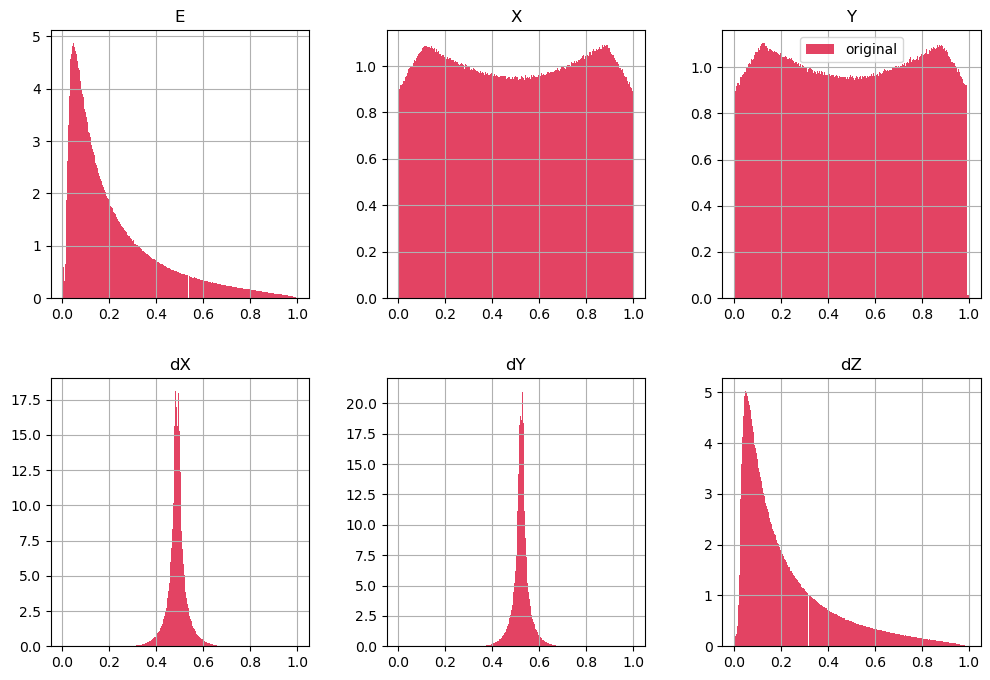

In [2]:
photons = np.load(f'{DATA_PATH}/photons_XYTE_E5.6_s0.0_a1.5.npy')
print(photons.shape)
mmsc = MinMaxScaler()
photons_mm = mmsc.fit_transform(photons)
figs, axs = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
plot_photons_histograms(photons_mm, axs, figs, title='')

In [4]:
def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    elif schedule == 'warmup50':
        betas = _warmup_beta(start, end, n_timesteps, 0.5)
    else:
        raise NotImplementedError(schedule)
    return betas


def _warmup_beta(start, end, n_timestep, warmup_frac):

    betas               = end * torch.ones(n_timestep)
    warmup_time         = int(n_timestep * warmup_frac)
    betas[:warmup_time] = torch.linspace(start, end, warmup_time)

    return betas


def extract(input, t):
    out = torch.gather(input, 0, t)  # gathers values along an axis (input, dim, index)
    return out.reshape((1,1))


def p_sample(model, x, t):
    t = torch.tensor([t]).to(device)
    # Factor to the model output
    eps_factor = ((1 - extract(alphas, t)) / extract(one_minus_alphas_bar_sqrt, t)).to(device)
    eps_theta = model(x, t).to(device)
    mean = (1 / extract(alphas, t).sqrt()) * (x - (eps_factor * eps_theta)).to(device)
    z = torch.randn_like(x).to(device)
    # Fixed sigma
    sigma_t = extract(betas, t).sqrt().to(device)
    sample = mean + sigma_t * z
    return (sample)


def p_sample_loop(model, shape):
    # noise from Gauss distribution
    cur_x = torch.randn(shape).to(device)
    # gradually denoise distribution
    for i in reversed(range(n_steps)):
        # print(i)
        cur_x = p_sample(model, cur_x, i)   
    x_seq = cur_x.detach().cpu()
    return x_seq


n_steps = 100   # change to the same number as in DDPM_cuda.ipynb
model = ConditionalModel(n_steps)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
batch_size = 10000

checkpoint = torch.load(f"{CKPT_PATH}/DDPM_XYTE_warmup50_epoch300.pt")
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
betas = make_beta_schedule(schedule='warmup50', n_timesteps=n_steps, start=1e-5, end=1e-2).to(device)


# Fixed computation of variables for all timesteps
alphas = 1 - betas
alphas = alphas.to(device)
alphas_prod = torch.cumprod(alphas, 0).to(device)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod).to(device)

In [5]:
num_photons = photons.shape[0]
iterations = int(num_photons/batch_size)
photons_generated = p_sample_loop(model, (batch_size, 6))
for t in range(iterations-1):
    generated = p_sample_loop(model, (batch_size, 6))
    photons_generated = torch.cat((photons_generated, generated))

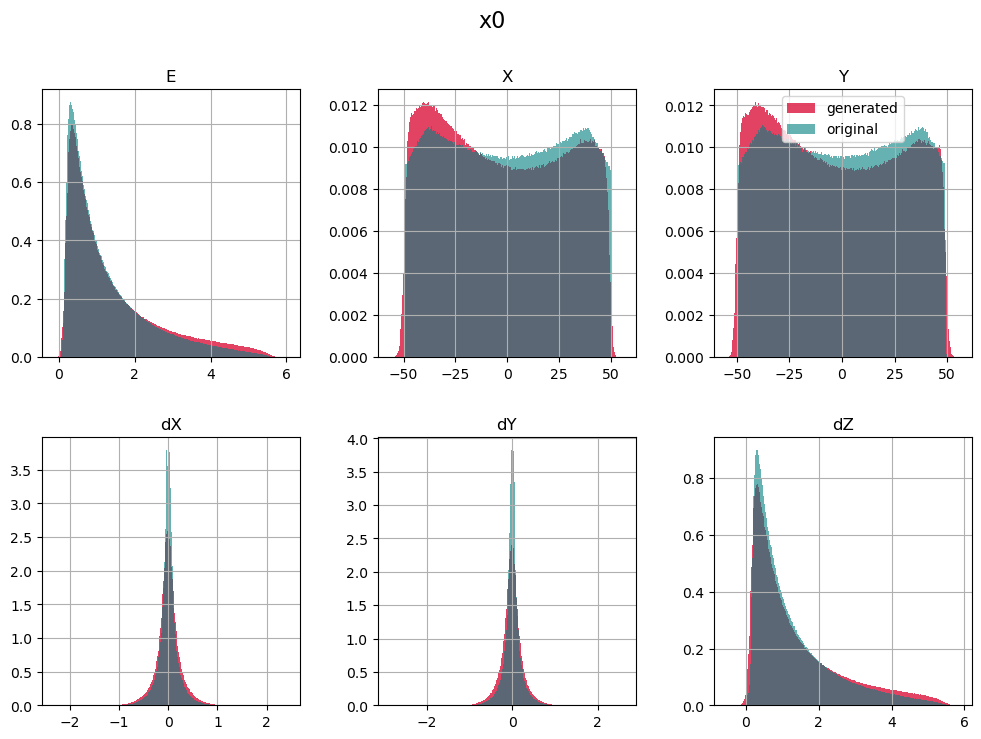

In [6]:
cur_x = photons_generated.detach()
inv_cur_x = mmsc.inverse_transform(cur_x.numpy())
figs, axs = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
plot_photons_histograms(inv_cur_x, axs, figs, title=f'x{0}', label='generated')
plot_photons_histograms(photons, axs, figs, data_color='teal', a=0.6)

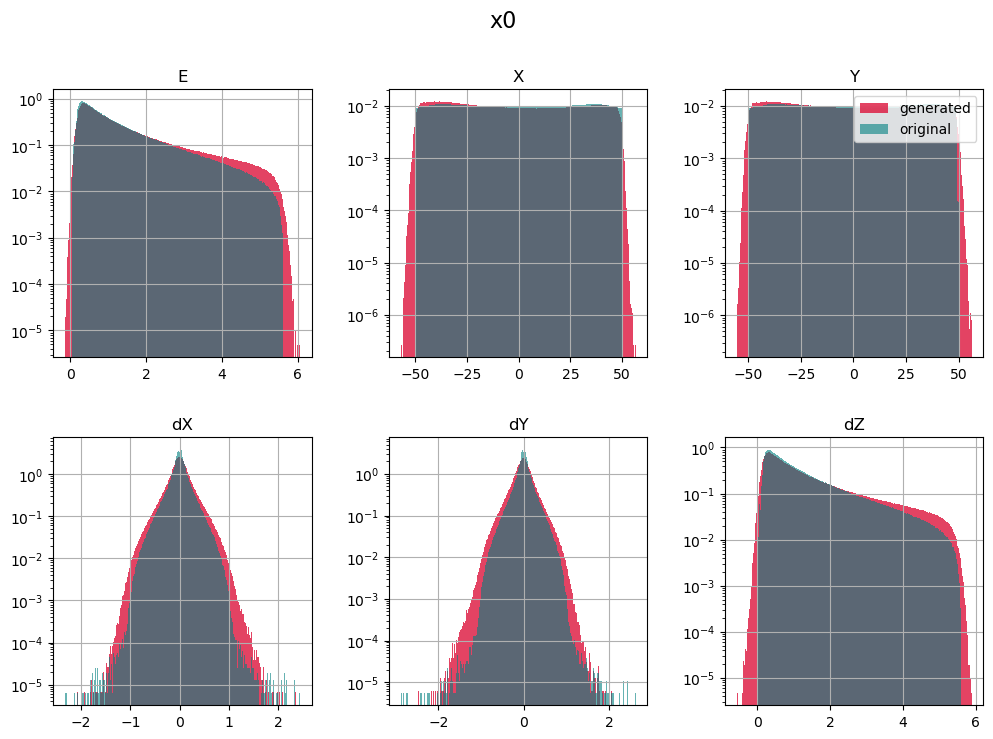

In [7]:
figs, axs = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
plot_photons_histograms(inv_cur_x, axs, figs, log_ax=True, title=f'x{0}', label='generated')
plot_photons_histograms(photons, axs, figs, log_ax=True, data_color='teal', a=0.6)

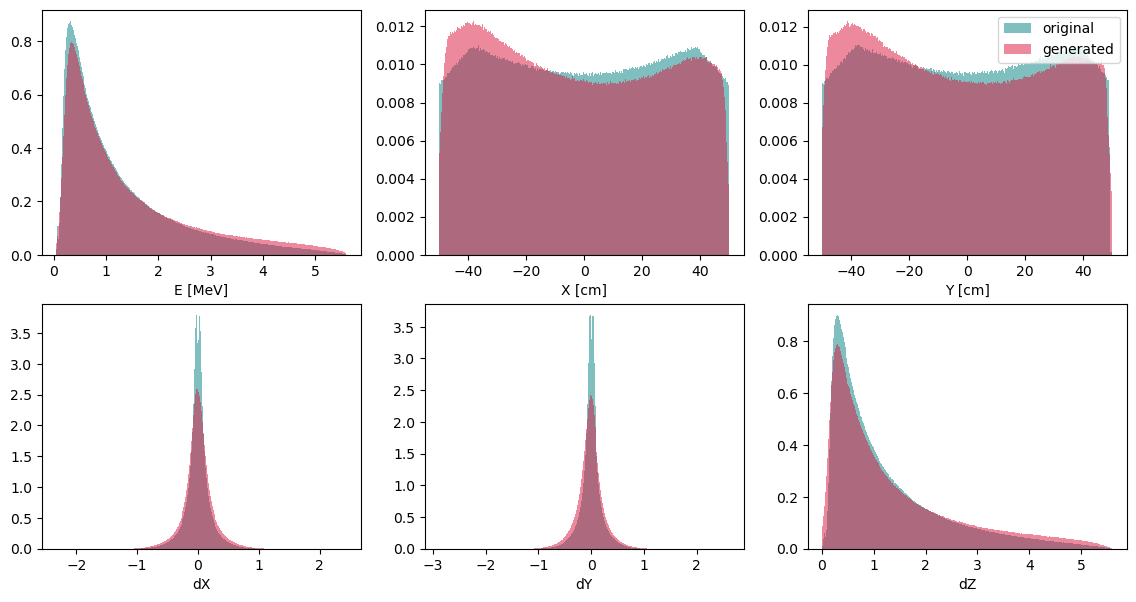

In [8]:
keys = ['E [MeV]', 'X [cm]', 'Y [cm]', 'dX', 'dY', 'dZ']
fig, axs = plt.subplots(2, 3, figsize=(14,7))
original_bins = {}
generated_bins = {}
bins_edges_raw = {}

for i, j in enumerate(keys):
    mi=photons[:, i].min()
    ma=photons[:, i].max()
    bins_edges_raw[j] = np.linspace(mi, ma, 300)
    original_bins[j] = axs.flatten()[i].hist(photons[:, i], bins=bins_edges_raw[j], alpha=.5, color='teal', label='original', density=True)[0]
    generated_bins[j] = axs.flatten()[i].hist(inv_cur_x[:, i], bins=bins_edges_raw[j], alpha=.5, color='crimson', label='generated', density=True)[0]
    axs.flatten()[i].set_xlabel(f'{j}')

axs.flatten()[2].legend(loc='upper right')
plt.show()

/tmp/ipykernel_4054/864362728.py:5: RuntimeWarning: invalid value encountered in double_scalars
  reduced_residuum_raw[j] = [(gen-orig)/orig for gen, orig in zip(generated_bins[j], original_bins[j])]
/tmp/ipykernel_4054/864362728.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  reduced_residuum_raw[j] = [(gen-orig)/orig for gen, orig in zip(generated_bins[j], original_bins[j])]


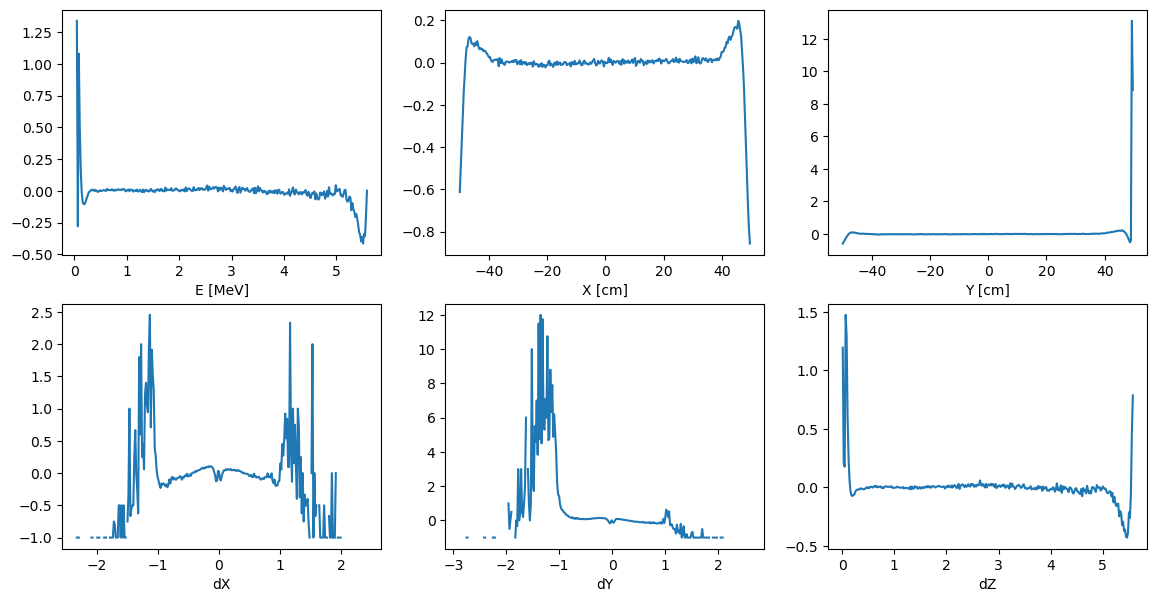

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(14,7))
reduced_residuum_raw = {}

for i, j in enumerate(keys):
    reduced_residuum_raw[j] = [(gen-orig)/orig for gen, orig in zip(generated_bins[j], original_bins[j])]
    axs.flatten()[i].plot(bins_edges_raw[j][:-1], reduced_residuum_raw[j])
    axs.flatten()[i].set_xlabel(f'{j}')

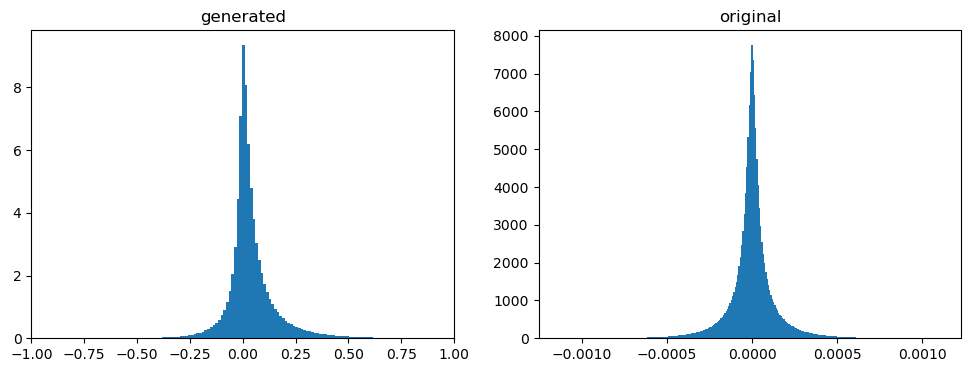

In [9]:
E_P_generated_raw = [
    inv_cur_x[i,0]**2 - (inv_cur_x[i,3]**2+inv_cur_x[i,4]**2+inv_cur_x[i,5]**2) for i in range(len(inv_cur_x[:,0]))
    ]
E_P_original = [photons[i,0]**2 - (photons[i,3]**2+photons[i,4]**2+photons[i,5]**2) for i in range(len(photons[:,0]))]
fig, axs = plt.subplots(ncols=2, figsize=(12,4))
axs[0].hist(E_P_generated_raw, bins=600, density=True, label='generated')
axs[1].hist(E_P_original, bins=300, density=True, label='original')
axs[0].set_title('generated')
axs[0].set_xlim(-1, 1)
axs[1].set_title('original')
plt.show()

In [11]:
EP_gen_np = np.array(E_P_generated_raw)
EP_orig_np = np.array(E_P_original)
print(f"Wartosc srednia wygenerowanego:{np.mean(EP_gen_np)} i oryginalnego: {np.mean(EP_orig_np)}")
print(f"Odchylenie standardowe wygenerowanego:{np.std(EP_gen_np)} i oryginalnego: {np.std(EP_orig_np)}")

Wartosc srednia wygenerowanego:0.03777690025921862 i oryginalnego: -4.0703313502205544e-08
Odchylenie standardowe wygenerowanego:0.1191289481238252 i oryginalnego: 0.0001365073435799603
